# Structure of the PSF HDF5 file

The input file containing the Point Spread Function (PSF) of the PLATO telescope is also provided as an HDF5 file. The PLATO Simulator software knows about the structure and how to select the correct PSF from the file.

The PSF HDF5 file contains currently only one group named **T6000** which represents the temperature (K) of the star for which the PSF is modelled. This group contains 15 children (also groups) that represent the PSF at a certains radial (gnomonic) distance from the optical axis of the telescope. These groups are called '`arxxxxx`' where `xxxxx` is the radial distance [deg] multiplied by 1000. So, the PSF of a star at radial distance 7.053 deg from the optical axis is located in the group `ar07053`.

Each group `arxxxxx` contains in turn 4 children (datasets) named `az0`, `az90`, `az180`, `az270`. These groups contain the PSFs for azimuth 0, 90, 180, and 270. These datasets each contain a number of attributes that completely define the PSF.


<img src="Structure of the PSF HDF5 file.png">

In [1]:
%matplotlib inline
%run -i setupMatplotlib.py

In [2]:
projectDir = '/Users/rik/Git/PlatoSim3'
workDir = '/Users/rik/Work/PLATO/Simulations'

%run -i setupEnvironment.py

In [3]:
import numpy as np
import tables

In [4]:
from simulation import Simulation

In [6]:
psfFile = tables.open_file(projectDir + "/inputfiles/psf.hdf5")

In [7]:
psfFile.root.T6000

/T6000 (Group) ''
  children := ['ar04238' (Group), 'ar18887' (Group), 'ar01414' (Group), 'ar18081' (Group), 'ar07053' (Group), 'ar11241' (Group), 'ar14001' (Group), 'ar02827' (Group), 'ar16730' (Group), 'ar05647' (Group), 'ar15370' (Group), 'ar09850' (Group), 'ar00000' (Group), 'ar08454' (Group), 'ar12625' (Group)]

In [8]:
psfFile.root.T6000.ar00000

/T6000/ar00000 (Group) ''
  children := ['az180' (Array), 'az270' (Array), 'az90' (Array), 'az0' (Array)]

In [9]:
psfFile.root.T6000.ar00000.az180._v_attrs

/T6000/ar00000/az180._v_attrs (AttributeSet), 9 attributes:
   [Xdeg := 0.0,
    Xfp := 0.0,
    Ydeg := 0.0,
    Yfp := 0.0,
    azimuth := 180,
    orientation := 45.0,
    radius := 0.0,
    temperature := 6000,
    vignetting := 0.0]

In [10]:
psfFile.root.T6000.ar00000.az180._v_attrs['temperature']

6000

In [11]:
psf = np.array(psfFile.root.T6000.ar16730.az180)

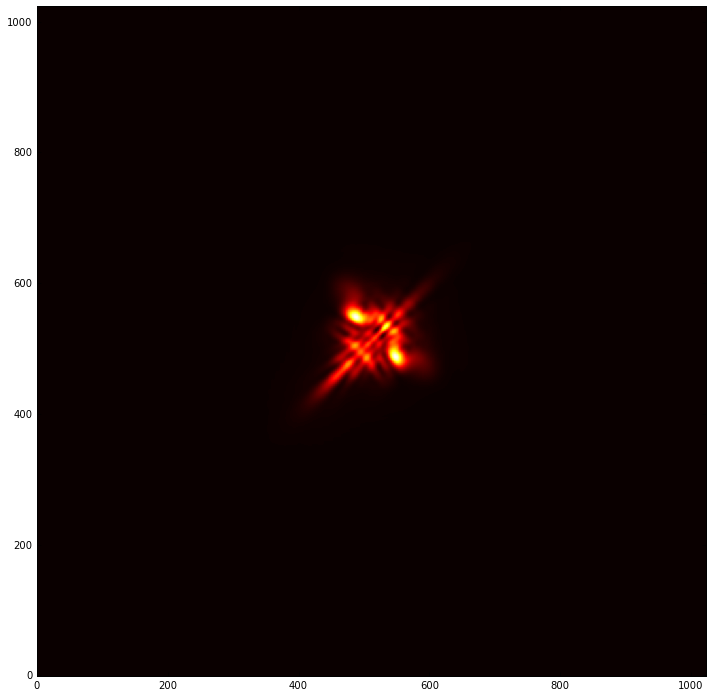

In [12]:
plt.imshow(psf, origin='lower', cmap=cm.hot, interpolation="nearest")

## How does PlatoSim select a PSF

The PSF is choosen based on the position of the subField on the CCD. The gnomonic radial distance of the center of the subField from the optical axis is calculated and used to select the proper `arxxxxx` dataset. Currently there is only one set of PSFs available, so all groups are populated with the same array data.

The user can specify the gnomonic radial distance to the optical axis in the configuration file with "PSF/DistanceToAO". This selects a specific PSF for that distance regardless the position of the subField on the CCD.

When the PSF data is selected and loaded, the array is rotated by a factor calculated from the focal plane coordinates of the center of the subField. The user is however allowed to specify a rotation angle in the configuration file through the input parameter "PSF/RotationAngle".

When the PSF is selected and rotated, the array will be rebinned to the number of sub-pixels per pixel used for the Detector. The number of sub-pixels per pixel that is used to model and render the current PSFs is 128. The PSFs are rendered over 8 pixels which makes the dataset arrays in the HDF5 file 1024 x 1024.

Since we only have one PSF per subField, the whole process of selecting, rotation and rebinning the PSF is done once during the start of the simulation, before looping over all exposures.

The selected PSF is saved in the output HDF5 file under the group 'PSF'. There are three PSF maps saved, the selected PSF, the rotated PSF and the rebinned PSF.

In [13]:
sim = Simulation("Run01", outputDir=workDir)

In [14]:
sim["PSF/Model"] = "FromFile"
sim["PSF/FromFile/DistanceToOA"] = 16.0

In [15]:
simFile = sim.run(removeOutputFile=True)

In [16]:
out = tables.open_file(workDir + "/Run01.hdf5")

In [17]:
out.root.PSF

/PSF (Group) ''
  children := ['rotatedPSF' (Array), 'rebinnedPSFpixel' (Array), 'rebinnedPSFsubPixel' (Array)]

In [18]:
rebinnedPSFsubPixel = np.array(out.root.PSF.rebinnedPSFsubPixel)

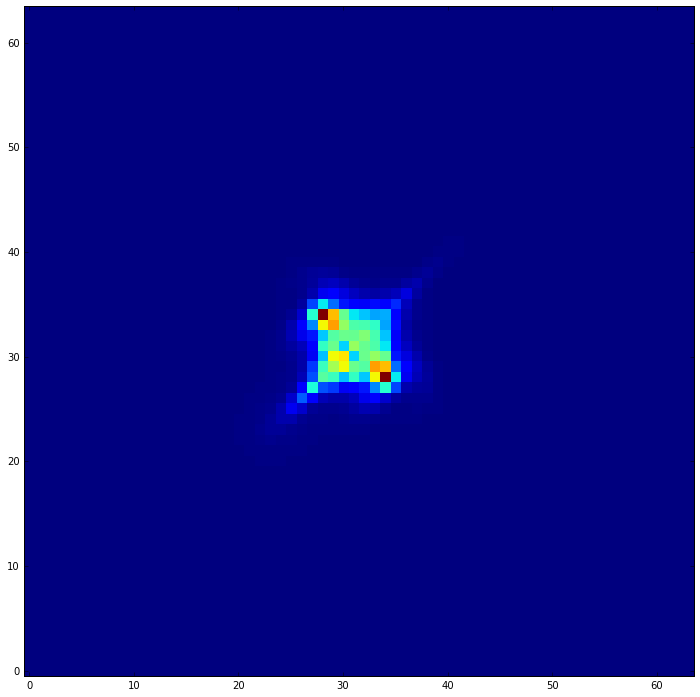

In [19]:
plt.imshow(rebinnedPSFsubPixel, origin='lower', interpolation='nearest')

In [20]:
rebinnedPSFpixel = np.array(out.root.PSF.rebinnedPSFpixel)

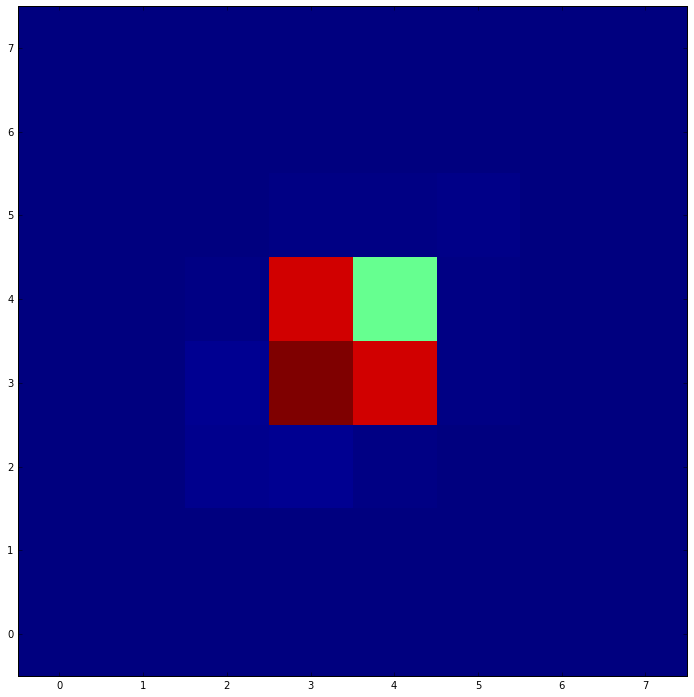

In [21]:
plt.imshow(rebinnedPSFpixel, origin='lower', interpolation='nearest')